In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

In [11]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(page.text, 'html.parser')

In [12]:
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))

In [13]:
new_df=df[0]

In [14]:
new_df.columns = new_df.iloc[0]


In [15]:
df = new_df.drop(new_df.index[0])
df.head()


,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


# Ignore rows which are having Borough as "Not Assigned"

In [16]:
df =df[df.Borough != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront
6,M5A,Downtown Toronto,Regent Park
7,M6A,North York,Lawrence Heights


# Combine duplicate Neighbourhood into single rows

In [17]:
df=df.groupby([df.Postcode,df.Borough],as_index=False).agg(', '.join)
df = df.rename(columns={'Postcode': 'Postal Code'})
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [18]:
df.loc[df.Neighbourhood=='Not assigned']

,Postal Code,Borough,Neighbourhood
85,M7A,Queen's Park,Not assigned


# Copying Borough information to Neighbourhood, if Neighbourhood is "Not Assigned"

In [19]:
df['Neighbourhood'] = np.where(df['Neighbourhood']=='Not assigned', df['Borough'], df['Neighbourhood'])


In [20]:
df.shape

(103, 3)

In [21]:
df.loc[df['Postal Code']=='M7A']

,Postal Code,Borough,Neighbourhood
85,M7A,Queen's Park,Queen's Park


In [22]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_7b26018035ef42589c01a5a6ebf99d05 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='htG0q0RjCMGyjV1L9XmSoiVShatc_ch6QaWInAd0eN8m',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_7b26018035ef42589c01a5a6ebf99d05.get_object(Bucket='xkkproject-donotdelete-pr-xtfdwaqqsjwbwa',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

ldf = pd.read_csv(body)
ldf.set_index('Postal Code',inplace=True)
ldf.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


# Making the original dataframe postal code as index for merging with the data frame coming from coursera for lat and longitude

In [23]:
df.set_index('Postal Code',inplace=True)
df.head()

,Borough,Neighbourhood
Postal Code,,
M1B,Scarborough,"Rouge, Malvern"
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [24]:
df=df.join(ldf)

In [25]:
df.head()

,Borough,Neighbourhood,Latitude,Longitude
Postal Code,,,,
M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


<function matplotlib.pyplot.show>

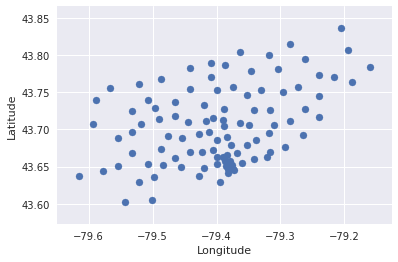

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
plt.scatter(df['Longitude'],df['Latitude'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show


# Cluster Analysis

In [49]:
x = df[['Longitude','Latitude']]
from sklearn import preprocessing

# scale the data for better results
x_scaled = preprocessing.scale(x)


In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(7)
kmeans.fit(x_scaled)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

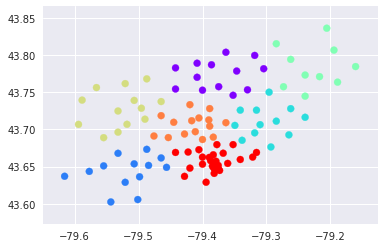

In [64]:
cluster_scaled = df.copy()
cluster_scaled['predict'] = kmeans.fit_predict(x_scaled)
plt.scatter(cluster_scaled['Longitude'], cluster_scaled['Latitude'], c= cluster_scaled ['predict'], cmap = 'rainbow')


# WCSS Computation and Elbow evaluation

In [61]:
wcss = []
cl_num = 15

for i in range(1,cl_num):
    kmeans = KMeans(i)
    kmeans.fit(x_scaled)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)


Text(0.5,0,'no of clusters')

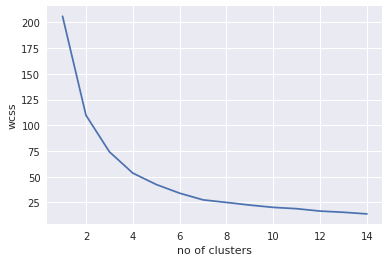

In [62]:
plt.plot(range(1,15),wcss)
plt.show
plt.ylabel('wcss')
plt.xlabel('no of clusters')

# Map Visualization

In [2]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import folium

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  54.16 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.96 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.48 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  45.22 MB/s


In [32]:
latitude =43.7
longitude = -79.383
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat,lan,borough in zip(df.Latitude,df.Longitude,df.Borough):
    
    label = '{}, {}, {}'.format(lat,lan,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lan],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto